In [ ]:
#% ! pip install -r requirements.txt

In [10]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import display, HTML
from dotenv import load_dotenv
from youtube_api_config import get_authenticated_service_with_api_key
# Import our custom modules
import sys
sys.path.append('.')  # Ensure modules in the current directory are importable
from youtube_api_config import (get_authenticated_service, get_channel_info, search_videos,
                        get_video_details, get_video_comments, get_subscription_data,
                        get_playlist_items, save_response_to_json, mask_sensitive_data)
from data_preprocessing import (extract_video_features, create_videos_dataframe,
                              extract_comment_features, create_comments_dataframe,
                              anonymize_dataframe)
from youtube_eda import (plot_video_statistics, create_word_cloud,
                                plot_time_distribution, plot_category_distribution,
                                create_summary_statistics)

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Optional: Configure logging (uncomment if needed)

logging.basicConfig(level=logging.INFO)

In [7]:
%pip install wordcloud

In [11]:
client_secrets_file = 'client_secret.json'

if not os.path.exists(client_secrets_file):
    print(f"WARNING: {client_secrets_file} not found!")
    print("Please follow these steps to set up API access:")
    print("1. Go to https://console.cloud.google.com/")
    print("2. Create a new project")
    print("3. Enable the YouTube Data API v3")
    print("4. Create OAuth 2.0 credentials")
    print("5. Download the credentials as client_secrets.json")
    print("6. Place the file in the current directory")
else:
    print(f"Found {client_secrets_file} ✓")


try:
    youtube = get_authenticated_service_with_api_key()
    print("Successfully authenticated with YouTube API ✓")
except Exception as e:
    print(f"Authentication failed: {str(e)}")

Found client_secret.json ✓
Successfully authenticated with YouTube API ✓


In [14]:
# Create a directory for storing data
data_dir = "youtube_data"
os.makedirs(data_dir, exist_ok=True)

# REMOVED: Personal channel info retrieval (requires OAuth, not API key)
# API key authentication can only access public data
channel_id = None
print("Note: Skipping personal channel info (API key only accesses public data)")
print("      To access personal data, use get_authenticated_service() instead\n")

# Search for videos related to data mining and analysis
search_queries = ["data mining techniques", "machine learning tutorial",
                 "data analysis python", "feature engineering",
                 "classification algorithms", "clustering data"]

all_video_ids = []
for query in search_queries:
    try:
        # Call search_videos with positional arguments
        search_response = search_videos(youtube, query, 10)
        save_response_to_json(search_response, f"{data_dir}/search_{query.replace(' ', '_')}.json")

        # Extract video IDs from search results
        video_ids = [item['id']['videoId'] for item in search_response.get('items', [])
                    if item['id']['kind'] == 'youtube#video']
        all_video_ids.extend(video_ids)

        print(f"Retrieved {len(video_ids)} videos for query: '{query}'")
    except Exception as e:
        print(f"Error searching for videos with query '{query}': {str(e)}")

# Remove duplicate video IDs
all_video_ids = list(set(all_video_ids))
print(f"\nTotal unique videos found: {len(all_video_ids)}")

# Get detailed information about the videos
all_videos_data = {"items": []}
comment_data = {"items": []}

# Process videos in batches of 50 (API limit)
print(f"\nRetrieving detailed information for {len(all_video_ids)} videos...")
for i in range(0, len(all_video_ids), 50):
    batch_ids = all_video_ids[i:i+50]
    try:
        video_response = get_video_details(youtube, batch_ids)
        all_videos_data["items"].extend(video_response)
        print(f"  Batch {i//50 + 1}: Retrieved {len(video_response)} videos")
    except Exception as e:
        print(f"  Error retrieving video details for batch {i//50 + 1}: {str(e)}")

print(f"\nTotal videos with details: {len(all_videos_data['items'])}")

# Save the complete video data
save_response_to_json(all_videos_data, f"{data_dir}/all_videos.json")
print(f"Saved video data to {data_dir}/all_videos.json")

# Get comments for each video (limited to 5 videos to avoid quota issues)
print(f"\nRetrieving comments for first 5 videos...")
for idx, video_id in enumerate(all_video_ids[:5], 1):
    try:
        comment_response = get_video_comments(youtube, video_id, max_results=20)
        if comment_response:
            comment_data["items"].extend(comment_response.get("items", []))
            print(f"  Video {idx}: Retrieved {len(comment_response.get('items', []))} comments")
        else:
            print(f"  Video {idx}: No comments available")
    except Exception as e:
        print(f"  Video {idx}: Error retrieving comments - {str(e)}")

# Save the comments data
save_response_to_json(comment_data, f"{data_dir}/video_comments.json")
print(f"\nSaved comments data to {data_dir}/video_comments.json")
print(f"Total comments collected: {len(comment_data['items'])}")

# REMOVED: Subscription data retrieval (requires OAuth authentication)
# API key cannot access personal subscription data
print("\nNote: Skipping subscription data (requires OAuth authentication)")

print("\n" + "="*60)
print("DATA COLLECTION COMPLETE!")
print("="*60)
print(f"Videos collected: {len(all_videos_data['items'])}")
print(f"Comments collected: {len(comment_data['items'])}")
print(f"Data saved in: {data_dir}/")
print("="*60)

Note: Skipping personal channel info (API key only accesses public data)
      To access personal data, use get_authenticated_service() instead

Retrieved 10 videos for query: 'data mining techniques'
Retrieved 10 videos for query: 'machine learning tutorial'
Retrieved 10 videos for query: 'data analysis python'
Retrieved 25 videos for query: 'feature engineering'
Retrieved 10 videos for query: 'classification algorithms'
Retrieved 10 videos for query: 'clustering data'

Total unique videos found: 74

Retrieving detailed information for 74 videos...
  Batch 1: Retrieved 50 videos
  Batch 2: Retrieved 24 videos

Total videos with details: 74
Saved video data to youtube_data/all_videos.json

Retrieving comments for first 5 videos...
  Video 1: Retrieved 20 comments
  Video 2: Retrieved 20 comments
  Video 3: Retrieved 20 comments
  Video 4: Retrieved 20 comments
  Video 5: Retrieved 20 comments

Saved comments data to youtube_data/video_comments.json
Total comments collected: 100

Note: 

In [15]:
# Load the collected data
try:
    with open(f"{data_dir}/all_videos.json", 'r', encoding='utf-8') as f:
        all_videos_data = json.load(f)

    with open(f"{data_dir}/video_comments.json", 'r', encoding='utf-8') as f:
        comment_data = json.load(f)

    # Process videos data
    video_features = extract_video_features(all_videos_data)
    videos_df = create_videos_dataframe(video_features)

    # Process comments data
    all_comments = []
    for item in comment_data.get('items', []):
        video_id = item.get('snippet', {}).get('videoId', '')
        comments = extract_comment_features({'items': [item]}, video_id)
        all_comments.extend(comments)

    comments_df = create_comments_dataframe(all_comments)

    # Mask sensitive information
    videos_df = anonymize_dataframe(videos_df, ['channel_title'])
    comments_df = anonymize_dataframe(comments_df, ['author_name', 'author_channel_id'])

    print(f"Processed {len(videos_df)} videos and {len(comments_df)} comments")

    # Save processed data to CSV
    videos_df.to_csv(f"{data_dir}/processed_videos.csv", index=False)
    comments_df.to_csv(f"{data_dir}/processed_comments.csv", index=False)

except Exception as e:
    print(f"Error during data preprocessing: {str(e)}")

Processed 74 videos and 100 comments


VIDEOS DATASET SUMMARY:
Number of videos: 74

Column names:
['video_id', 'title', 'description', 'channel_title', 'published_at', 'channel_id', 'duration', 'dimension', 'definition', 'view_count', 'like_count', 'comment_count', 'favorite_count', 'dislike_count', 'likes_per_view', 'comments_per_view', 'engagement_score']


,video_id,title,description,channel_title,published_at,channel_id,duration,dimension,definition,view_count,like_count,comment_count,favorite_count,dislike_count,likes_per_view,comments_per_view,engagement_score
0,GPVsHOlRBBI,"Data Analysis with Python Course - Numpy, Pand...","Learn the basics of Python, Numpy, Pandas, Dat...",Masked_7596,2021-02-18 17:03:50+00:00,UC8butISFwT-Wl7EV0hUK0BQ,35783,2d,hd,3147386,73026,875,0,0,0.023202,0.000278,0.023758
1,xhB-dmKmzRk,Step By Step Process In EDA And Feature Engine...,⭐ Kite is a free AI-powered coding assistant t...,Masked_4378,2021-08-29 12:31:32+00:00,UCNU_lfiiWBdtULKOw6X0Dig,859,2d,hd,206951,5859,84,0,0,0.028311,0.000406,0.029123
2,r-uOLxNrNk8,Data Analysis with Python - Full Course for Be...,Learn Data Analysis with Python in this compre...,Masked_7596,2020-04-15 13:19:55+00:00,UC8butISFwT-Wl7EV0hUK0BQ,15733,2d,hd,4001229,80096,1089,0,0,0.020018,0.000272,0.020562
3,_L39rN6gz7Y,"Decision and Classification Trees, Clearly Exp...",Decision trees are part of the foundation for ...,Masked_4582,2021-04-26 04:00:08+00:00,UCtYLUTtgS3k1Fg4y5tAhLbw,1088,2d,hd,1126830,22788,982,0,0,0.020223,0.000871,0.021966
4,esmzYhuFnds,12. Clustering,MIT 6.0002 Introduction to Computational Think...,Masked_5713,2017-05-19 14:22:41+00:00,UCEBb1b_L6zDS3xTUrIALZOw,3040,2d,hd,340241,4370,122,0,0,0.012844,0.000359,0.013561


,count,mean,std,min,25%,50%,75%,max,range,iqr,cv,missing,missing_pct,type,unique,top,freq,freq_pct
duration,74.0,2619.121622,6.624429e+03,16.0,322.000000,568.000000,1797.250000,4.018100e+04,4.016500e+04,1475.250000,2.529256,0,0.0,NaN,NaN,NaN,NaN,NaN
view_count,74.0,664104.689189,1.474440e+06,105.0,17385.500000,106464.500000,428376.000000,9.508075e+06,9.507970e+06,410990.500000,2.220192,0,0.0,NaN,NaN,NaN,NaN,NaN
like_count,74.0,12657.783784,2.306552e+04,0.0,274.750000,1967.000000,10341.750000,1.009190e+05,1.009190e+05,10067.000000,1.822240,0,0.0,NaN,NaN,NaN,NaN,NaN
comment_count,74.0,313.689189,5.728324e+02,0.0,7.250000,48.000000,408.250000,2.453000e+03,2.453000e+03,401.000000,1.826115,0,0.0,NaN,NaN,NaN,NaN,NaN
favorite_count,74.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN
dislike_count,74.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN
likes_per_view,74.0,0.022382,1.276709e-02,0.0,0.013159,0.020120,0.029091,5.465839e-02,5.465839e-02,0.015932,0.570413,0,0.0,NaN,NaN,NaN,NaN,NaN
comments_per_view,74.0,0.000805,1.582204e-03,0.0,0.000174,0.000423,0.000773,1.192748e-02,1.192748e-02,0.000598,1.964639,0,0.0,NaN,NaN,NaN,NaN,NaN
engagement_score,74.0,0.023993,1.420489e-02,0.0,0.013787,0.021521,0.031856,6.488550e-02,6.488550e-02,0.018068,0.592047,0,0.0,NaN,NaN,NaN,NaN,NaN
video_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,object,74.0,GPVsHOlRBBI,1.0,1.351351


/content/youtube_eda.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='view_count', y='title', data=df_sorted, ax=ax1, palette='viridis')
/content/youtube_eda.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([title[:50] + '...' if len(title) > 50 else title
/content/youtube_eda.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='engagement_rate', y='title', data=df_sorted, ax=ax2, palette='plasma')
/content/youtube_eda.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(

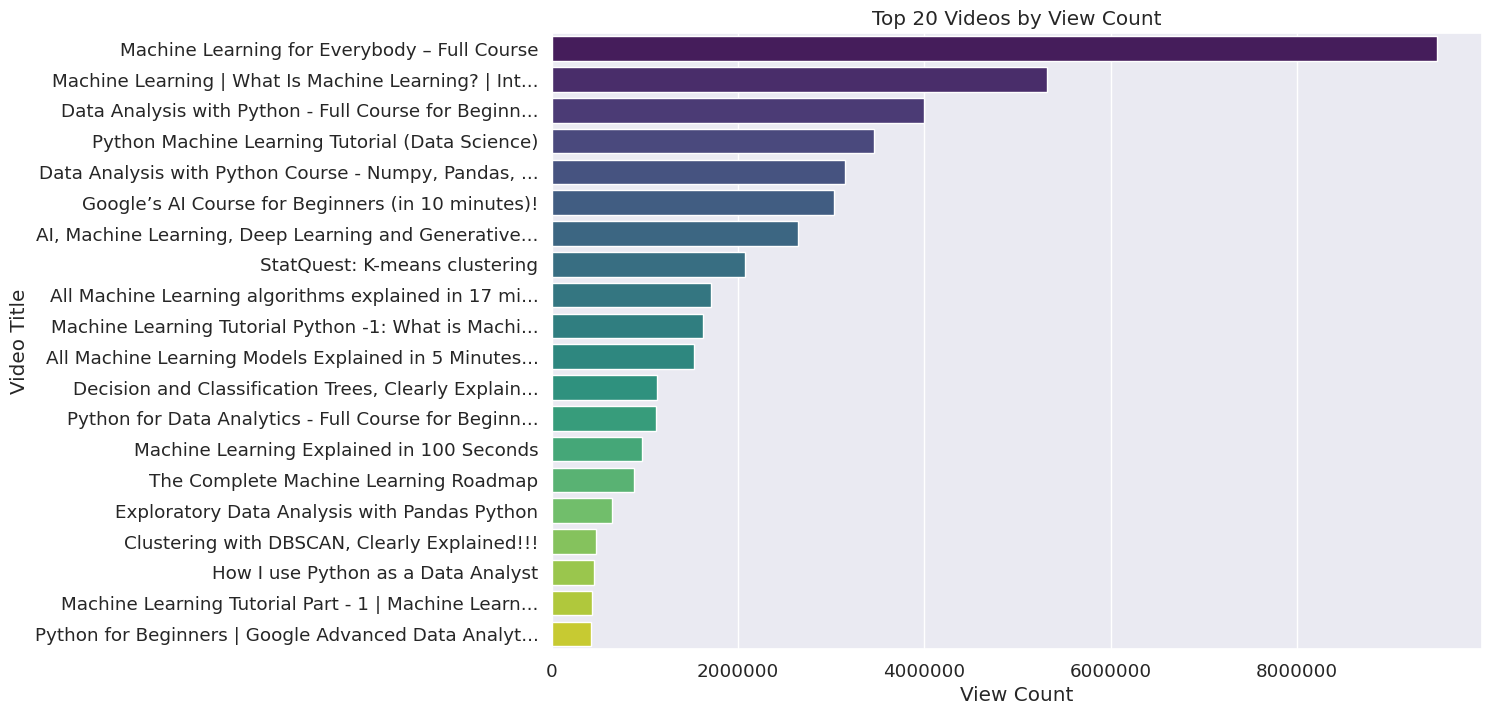

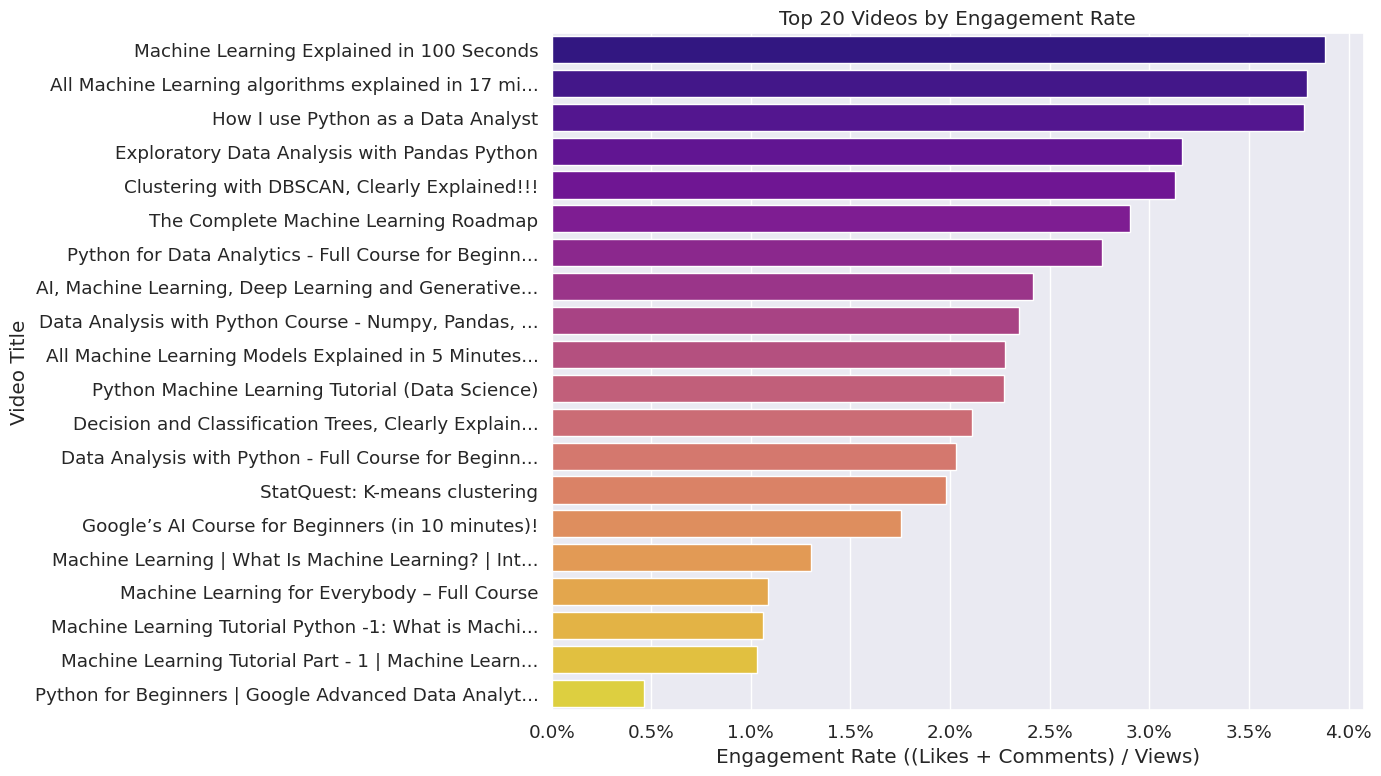

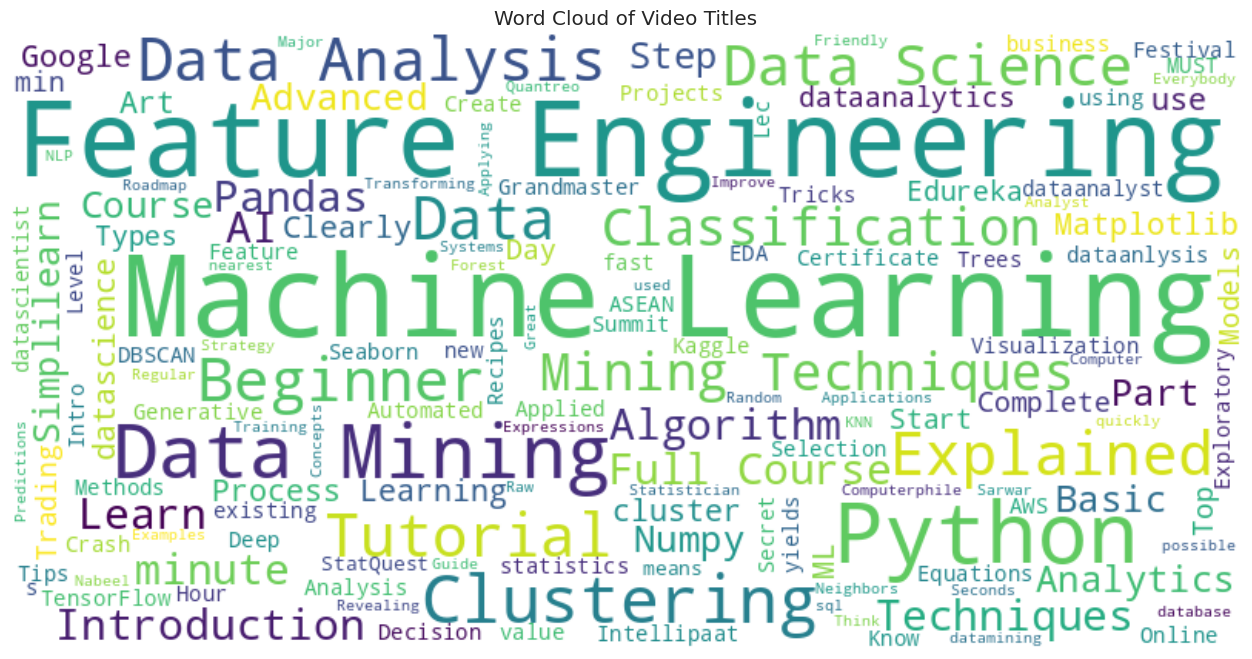

/content/youtube_eda.py:131: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.resample('M', on=date_column).size()


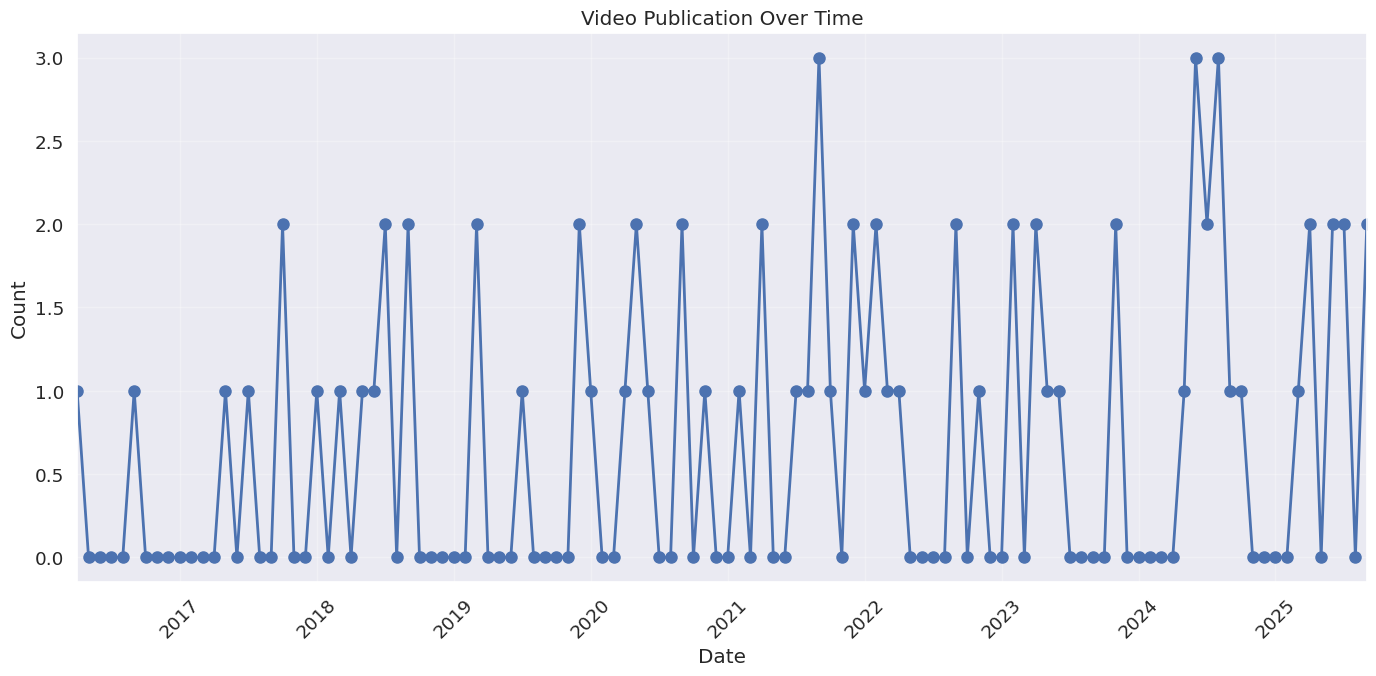


COMMENTS DATASET SUMMARY:
Number of comments: 100

Column names:
['comment_id', 'video_id', 'text', 'author_name', 'author_channel_id', 'published_at', 'like_count', 'reply_count', 'text_length', 'word_count']


,comment_id,video_id,text,author_name,author_channel_id,published_at,like_count,reply_count,text_length,word_count
0,UgzxjtrGvdq1Lp09QxR4AaABAg,GPVsHOlRBBI,Will be finishing this in 2 days. And come her...,Masked_8969,Masked_0771,2026-01-03 11:34:22+00:00,1,1,66,12
1,UgwZ3BMYJYk5PZh0sNl4AaABAg,GPVsHOlRBBI,with this quality of teaching for free on yout...,Masked_3644,Masked_9764,2026-01-02 16:55:30+00:00,0,0,65,14
2,Ugyxj2tHSfnAU6FG_sV4AaABAg,GPVsHOlRBBI,"its not free anymore, its asking for money in ...",Masked_5162,Masked_2703,2025-12-21 09:46:57+00:00,1,0,74,14
3,Ugx2kFcDWzLpPh9JsmJ4AaABAg,GPVsHOlRBBI,Found someone else on that twitter id,Masked_1116,Masked_6452,2025-12-21 02:46:16+00:00,0,0,37,7
4,Ugy1cypMa6wYUWScBPh4AaABAg,GPVsHOlRBBI,misleading 10 hr course time. Took me almost 1...,Masked_6999,Masked_7799,2025-12-20 17:49:17+00:00,0,0,68,13


,count,mean,std,min,25%,50%,75%,max,range,iqr,cv,missing,missing_pct,type,unique,top,freq,freq_pct
like_count,100.0,5.90,30.948801,0.0,0.00,0.0,1.00,218.0,218.0,1.0,5.245559,0,0.0,NaN,NaN,NaN,NaN,NaN
reply_count,100.0,0.65,2.508068,0.0,0.00,0.0,1.00,24.0,24.0,1.0,3.858566,0,0.0,NaN,NaN,NaN,NaN,NaN
text_length,100.0,139.93,365.685941,2.0,34.25,71.0,105.75,3575.0,3573.0,71.5,2.613349,0,0.0,NaN,NaN,NaN,NaN,NaN
word_count,100.0,18.87,45.977521,1.0,4.75,8.0,15.25,444.0,443.0,10.5,2.436541,0,0.0,NaN,NaN,NaN,NaN,NaN
comment_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,object,100.0,UgzxjtrGvdq1Lp09QxR4AaABAg,1.0,1.0
video_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,object,5.0,GPVsHOlRBBI,20.0,20.0
text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,object,100.0,Will be finishing this in 2 days. And come her...,1.0,1.0
author_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,object,92.0,Masked_5958,5.0,5.0
author_channel_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,object,92.0,Masked_6467,5.0,5.0


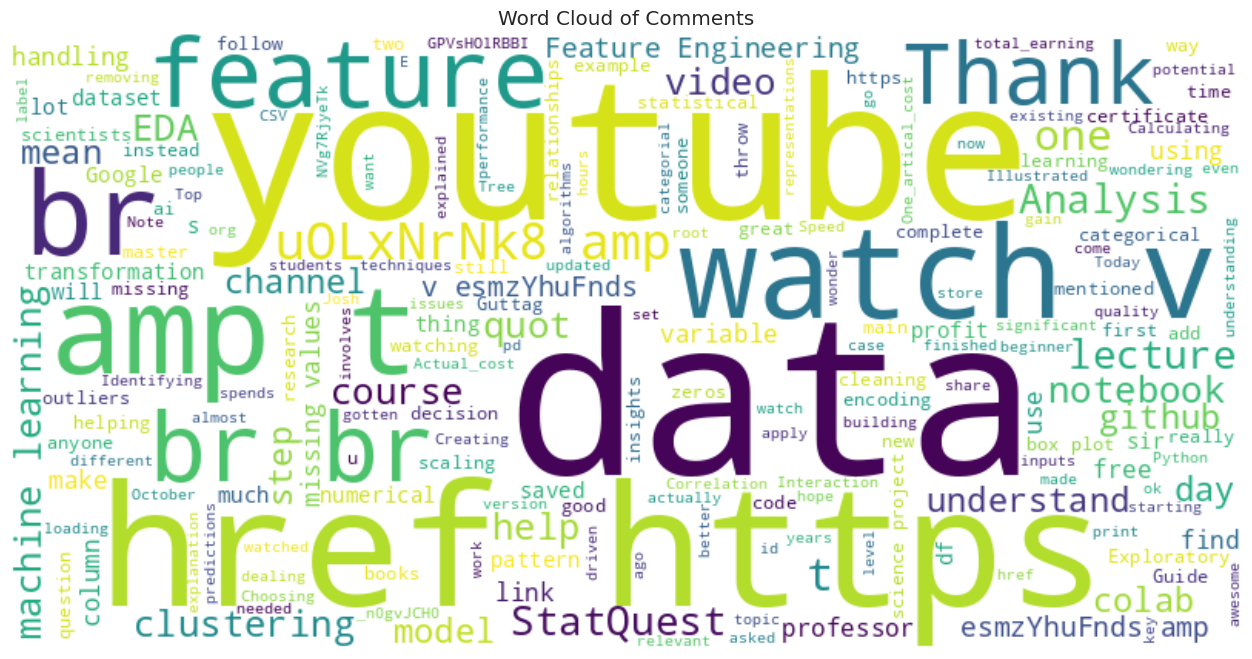

In [16]:
# Display basic statistics about the video dataset
if 'videos_df' in locals() and not videos_df.empty:
    print("VIDEOS DATASET SUMMARY:")
    print(f"Number of videos: {len(videos_df)}")
    print("\nColumn names:")
    print(videos_df.columns.tolist())

    # Show the first few rows
    display(videos_df.head())

    # Create summary statistics
    video_stats = create_summary_statistics(videos_df)
    display(video_stats)

    # Plot video statistics
    try:
        fig1, fig2 = plot_video_statistics(videos_df)
        plt.show()
    except Exception as e:
        print(f"Error creating video statistics plots: {str(e)}")

    # Create a word cloud from video titles
    try:
        title_wordcloud = create_word_cloud(videos_df, 'title')
        plt.show()
    except Exception as e:
        print(f"Error creating word cloud: {str(e)}")

    # Plot publication time distribution
    try:
        time_plot = plot_time_distribution(videos_df, 'published_at')
        plt.show()
    except Exception as e:
        print(f"Error creating time distribution plot: {str(e)}")

# Display basic statistics about the comments dataset
if 'comments_df' in locals() and not comments_df.empty:
    print("\nCOMMENTS DATASET SUMMARY:")
    print(f"Number of comments: {len(comments_df)}")
    print("\nColumn names:")
    print(comments_df.columns.tolist())

    # Show the first few rows
    display(comments_df.head())

    # Create summary statistics
    comment_stats = create_summary_statistics(comments_df)
    display(comment_stats)

    # Create a word cloud from comment text
    try:
        comment_wordcloud = create_word_cloud(comments_df, 'text')
        plt.show()
    except Exception as e:
        print(f"Error creating comment word cloud: {str(e)}")

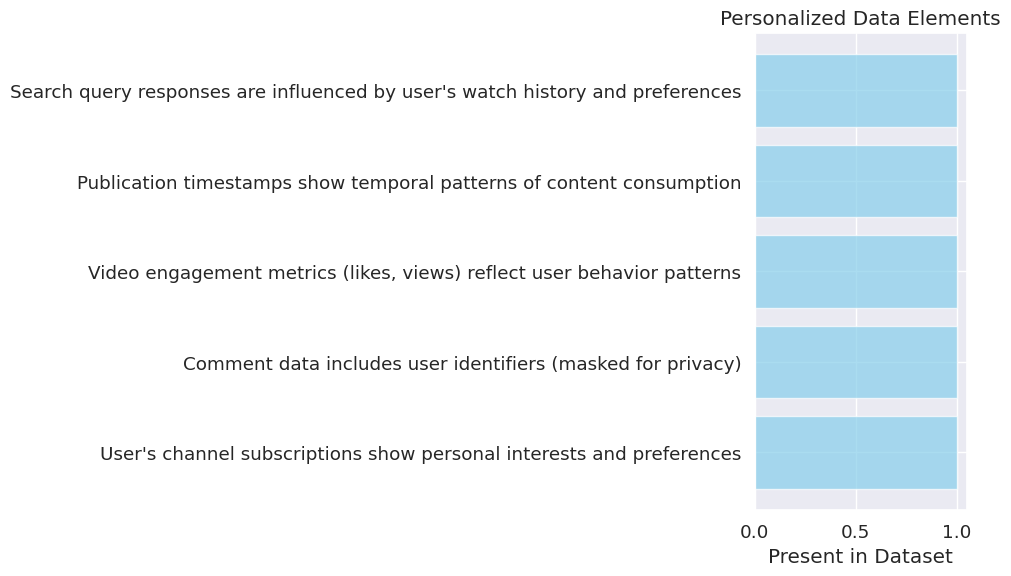

Examples of Personalized Data Elements (Masked for Privacy):
1. User Channel Information:
   - No channel information available

2. Comment Data (User Engagement):
   - Number of different users commenting: 92
   - Comment Author Examples (Masked):
     * Masked_8969
     * Masked_3644
     * Masked_5162
     * Masked_1116
     * Masked_6999

3. Video Preferences:
   - Most common topics in watched videos:


,count
data,35
machine,31
feature,28
learning,26
engineering,25
python,16
what,14
is,13
mining,11
techniques,10


In [17]:
# Identify and document personalized data elements
personalized_elements = [
    "User's channel subscriptions show personal interests and preferences",
    "Comment data includes user identifiers (masked for privacy)",
    "Video engagement metrics (likes, views) reflect user behavior patterns",
    "Publication timestamps show temporal patterns of content consumption",
    "Search query responses are influenced by user's watch history and preferences"
]

# Create a visual representation of personalized data aspects
plt.figure(figsize=(10, 6))
y_pos = range(len(personalized_elements))
plt.barh(y_pos, [1] * len(personalized_elements), align='center', alpha=0.7, color='skyblue')
plt.yticks(y_pos, personalized_elements)
plt.xlabel('Present in Dataset')
plt.title('Personalized Data Elements')
plt.tight_layout()
plt.show()

# Show specific examples of personalized data (with sensitive information masked)
print("Examples of Personalized Data Elements (Masked for Privacy):")
print("1. User Channel Information:")
if 'channel_response' in locals() and channel_response.get('items'):
    channel = channel_response['items'][0]
    print(f"   - Channel Title: [MASKED for privacy]")
    print(f"   - Subscription Count: {channel.get('statistics', {}).get('subscriberCount', 'N/A')}")
    print(f"   - Video Count: {channel.get('statistics', {}).get('videoCount', 'N/A')}")
else:
    print("   - No channel information available")

print("\n2. Comment Data (User Engagement):")
if 'comments_df' in locals() and not comments_df.empty:
    print(f"   - Number of different users commenting: {comments_df['author_name'].nunique()}")
    print("   - Comment Author Examples (Masked):")
    for author in comments_df['author_name'].unique()[:5]:
        print(f"     * {author}")
else:
    print("   - No comment data available")

print("\n3. Video Preferences:")
if 'videos_df' in locals() and not videos_df.empty:
    # Show distribution of video categories or topics
    title_words = ' '.join(videos_df['title'].fillna('').astype(str)).lower().split()

    # Define stopwords to remove
    stopwords = ['a', 'the', 'and', 'to', 'of', 'in', 'for', 'on', 'with', 'how', '-', '|']

    # Get word counts
    word_counts = pd.Series(title_words).value_counts()

    # Only drop words that exist in the series
    words_to_drop = [word for word in stopwords if word in word_counts.index]
    word_counts = word_counts.drop(words_to_drop)

    print("   - Most common topics in watched videos:")
    display(word_counts.head(10))
else:
    print("   - No video data available")

In [21]:
report_sections = {
    "Data Sources Considered": [
        "YouTube Data API (selected)",
        "Twitter API (rejected due to access limitations)",
        "Reddit API (rejected due to less personalized data)",
        "Spotify API (rejected as less relevant to data mining course topics)"
    ],
    "Selected Dataset Justification": [
        "Rich personalized user data available",
        "Contains both structured and unstructured data",
        "Accessible through well-documented API",
        "High relevance to data mining techniques taught in the course",
        "Data includes engagement metrics suitable for predictive modeling"
    ],
    "Data Statistics": [
        f"Number of videos collected: {len(videos_df) if 'videos_df' in locals() else 'N/A'}",
        f"Number of comments collected: {len(comments_df) if 'comments_df' in locals() else 'N/A'}",
        f"Number of unique commenters: {comments_df['author_name'].nunique() if 'comments_df' in locals() else 'N/A'}",
        f"Average video view count: {videos_df['view_count'].mean() if 'videos_df' in locals() else 'N/A':.2f}",
        f"Average comments per video: {len(comments_df)/len(videos_df) if 'comments_df' in locals() and 'videos_df' in locals() and len(videos_df) > 0 else 'N/A':.2f}"
    ],
    "Preprocessing Steps": [
        "Data extraction from YouTube API responses",
        "Structuring data into video and comment datasets",
        "Feature engineering (e.g., engagement metrics, video duration)",
        "Privacy protection through masking of personal identifiers",
        "Data cleaning and formatting"
    ],
    "Potential Data Mining Applications": [
        "Classification of video popularity based on metadata",
        "Sentiment analysis of comments",
        "Clustering videos based on engagement patterns",
        "Topic modeling to identify content themes",
        "Association rule mining for content recommendation",
        "Anomaly detection for identifying unusual engagement patterns"
    ]
}

# Build Markdown report content
report_md = "# Data Collection Report\n"

for section, items in report_sections.items():
    report_md += f"\n## {section}\n"
    for item in items:
        report_md += f"- {item}\n"

# Write to file
with open(f"{data_dir}/data_collection_report.md", 'w', encoding='utf-8') as report_file:
    report_file.write(report_md)

print("Report saved successfully to data_collection_report.md")


Report saved successfully to data_collection_report.md
